In [1]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime
from os import listdir, walk
from os.path import isfile, join

'''Data Viz'''
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import Grid
%matplotlib inline

import seaborn as sns
color = sns.color_palette()

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
from sklearn.metrics import adjusted_rand_score
import random

'''Algos'''
from kshape.core import kshape, zscore
import tslearn
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import KShape, TimeSeriesKMeans
import hdbscan

C:\ProgramData\Anaconda3\lib\site-packages\tslearn\clustering\kmeans.py:16: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  warnings.warn(


In [9]:
# CSVファイルの読み込み
df = pd.read_csv('train.csv', header=0)
# データの先頭を確認

# 元のラベル列を抽出（1列目をラベルとする）
labels = df.iloc[:, 0]

df.head()

,1,0.009913395,0.033428888,-0.005763601,-0.029279094,-0.052794587,0.009913395.1,-0.021440596,-0.029279094.1,-0.060633085,...,-0.091987075.3,0.002074897.2,-0.04495609.1,-0.060633085.8,-0.068471582.3,0.002074897.3,-0.029279094.5,-0.11550256,0.002074897.4,0.02559039.2
0,1,0.073039,0.032245,0.040404,0.048563,0.032245,0.052642,0.040404,0.015928,0.015928,...,-0.371614,-0.371614,-0.420566,-0.363455,-0.387931,-0.387931,-0.404249,-0.387931,-0.375693,-0.404249
1,2,1.908786,0.368965,0.340811,0.322041,0.350195,0.350195,0.378350,0.331426,0.378350,...,-0.062731,-0.081500,0.021731,0.153117,0.143732,0.331426,0.002962,-0.297348,-0.278579,-0.353656
2,2,-0.480461,-0.470177,-0.377624,-0.429042,-0.429042,-0.449610,-0.377624,-0.315922,-0.449610,...,-0.110247,-0.233652,-0.336489,-0.408475,-0.583298,-0.511312,-0.387908,-0.367340,-0.377624,-0.367340
3,1,0.335308,0.298158,0.298158,0.288870,0.307445,0.223857,0.242432,0.261008,0.158844,...,-0.305533,-0.379834,-0.333396,-0.351971,-0.324108,-0.314821,-0.351971,-0.324108,-0.379834,-0.407696
4,2,0.246891,0.246891,0.272247,0.251962,0.206320,0.196178,0.241819,0.196178,0.186035,...,0.206320,-0.042174,-0.174028,-0.174028,-0.305882,-0.270383,-0.331238,-0.331238,-0.321096,-0.326167


In [10]:
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans
import numpy as np

# 必要な列を抽出（最初の列はインデックスとして扱う）
data = df.iloc[:, 1:].values

# データを正規化
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

In [25]:
# データの形状を3次元に変換 (必要に応じてreshape)
reshaped_data = scaled_data.reshape(scaled_data.shape[0], 1, scaled_data.shape[1])

# TimeSeriesKMeansによるクラスタリング
model = TimeSeriesKMeans(n_clusters=2, metric="dtw", random_state=10)
clusters = model.fit_predict(reshaped_data)

In [26]:
# クラスタリング結果が 0, 1, 2 で返ってくるので、これを 1 または 2 に変換
# 例として、0 を 1 に、1 を 2 にマッピングします
adjusted_clusters = [x + 1 for x in clusters]

# 調整後のクラスタリング結果をデータフレームに追加
df['adjusted_cluster'] = adjusted_clusters

# ラベルと調整後のクラスタリング結果を比較
comparison_df = pd.DataFrame({'Label': labels, 'Cluster': adjusted_clusters})

# 比較結果の表示
print(comparison_df.head())

   Label  Cluster
0      1        1
1      2        2
2      2        2
3      1        2
4      2        2


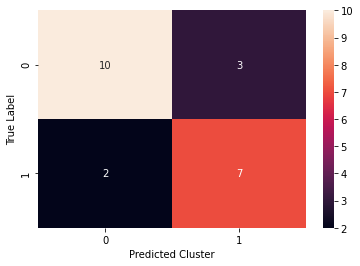

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 混同行列の作成
conf_matrix = confusion_matrix(labels, adjusted_clusters)

# 混同行列の表示
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted Cluster')
plt.ylabel('True Label')
plt.show()

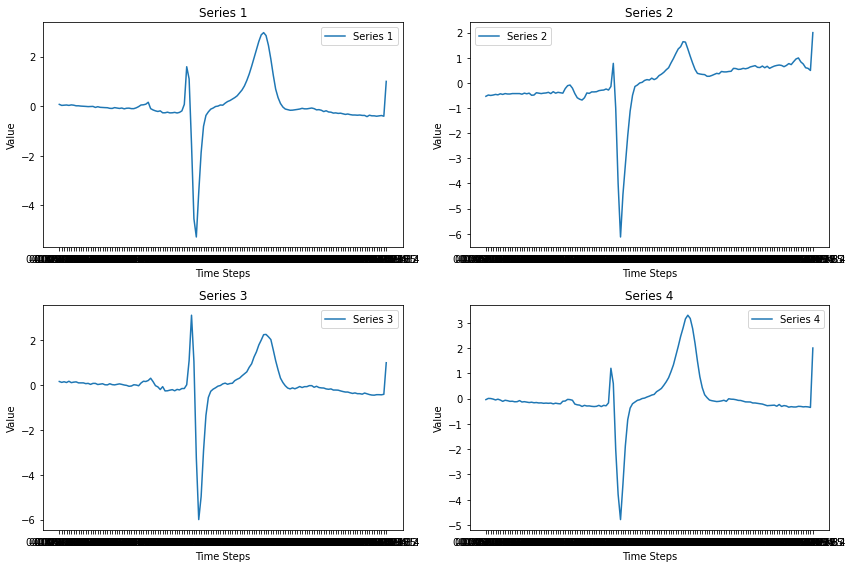

In [28]:
import matplotlib.pyplot as plt

# クラスタリング結果が1のデータを抽出
cluster_1_data = df[df['adjusted_cluster'] == 1].iloc[:, 1:-1]

# 2x2のプロットを作成
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 4つの時系列データをプロット
for i, ax in enumerate(axes.flatten()):
    ax.plot(cluster_1_data.iloc[i], label=f'Series {i+1}')
    ax.set_title(f'Series {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Value')
    ax.legend()

plt.tight_layout()
plt.show()

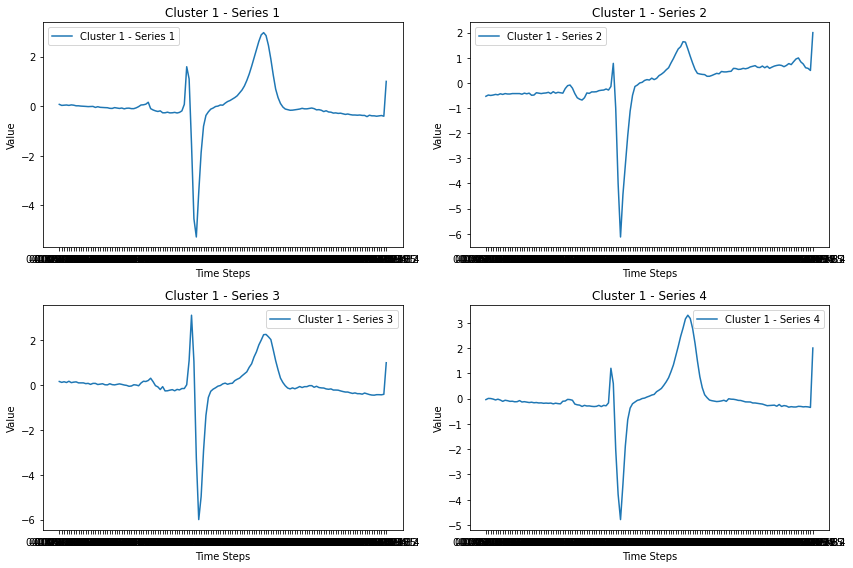

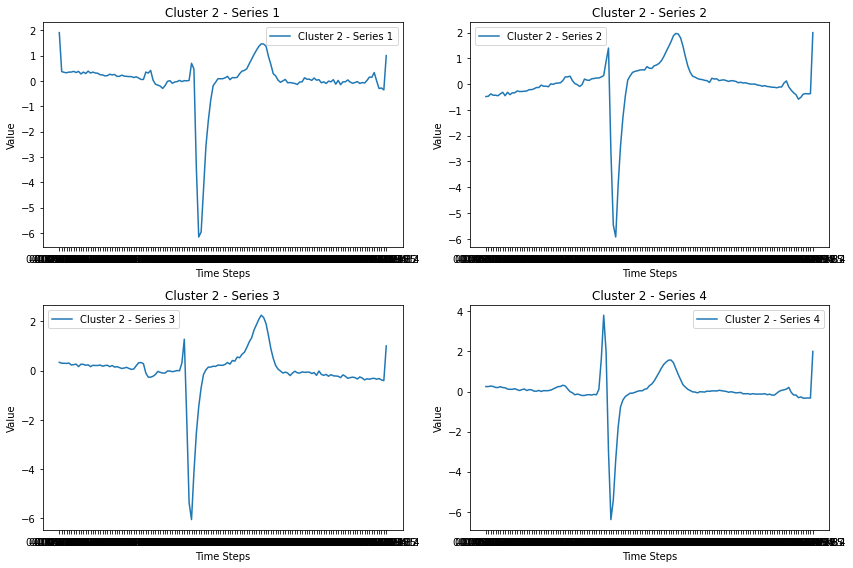

In [29]:
import matplotlib.pyplot as plt

# クラスタリング結果が1のデータを抽出
cluster_1_data = df[df['adjusted_cluster'] == 1].iloc[:, 1:-1]

# クラスタリング結果が2のデータを抽出
cluster_2_data = df[df['adjusted_cluster'] == 2].iloc[:, 1:-1]

# 図を2行2列で作成
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# クラスタ1の4つの時系列データを2x2でプロット
for i, ax in enumerate(axes.flatten()):
    if i < 4:  # 最初の4つはクラスタ1
        ax.plot(cluster_1_data.iloc[i], label=f'Cluster 1 - Series {i+1}')
        ax.set_title(f'Cluster 1 - Series {i+1}')
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Value')
        ax.legend()

plt.tight_layout()
plt.show()


